In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
from casacore.tables import table

import glob
import numpy as np

import katdal 
from scikits.fitting import ScatterFit, GaussianFit
import katpoint

from ska_sdp_datamodels.visibility import create_visibility_from_ms
from ska_sdp_func_python.calibration import solve_gaintable 

In [2]:
# Beam fitting routine 
def _fwhm_to_sigma(fwhm):
    """
    Standard deviation of Gaussian function with specified
    FWHM beamwidth.

    :param fwhm: Full-width half-maximum (FWHM) beamwidth
    :return: The standard deviation of a Gaussian beam pattern
    with a specified full-width half-maximum (FWHM) beamwidth.
    This beamwidth is the width between the two points left and
    right of the peak where the Gaussian function attains half
    its maximum value
    """
    # Gaussian function reaches half its peak value at sqrt(2 log 2)*sigma
    return fwhm / 2.0 / np.sqrt(2.0 * np.log(2.0))


def _sigma_to_fwhm(sigma):
    """
    FWHM beamwidth of Gaussian function with specified standard
    deviation.

    :param sigma: The standard deviation of a Gaussian beam pattern
    with a specified full-width half-maximum (FWHM) beamwidth
    :return: The full-width half-maximum (FWHM) beamwidth of a Gaussian
    beam pattern with a specified standard deviation. This beamwidth
    is the width between the two points left and right of the peak
    where the Gaussian function attains half its maximum value
    """
    # Gaussian function reaches half its peak value at sqrt(2 log 2)*sigma
    return 2.0 * np.sqrt(2.0 * np.log(2.0)) * sigma

class BeamPatternFit(ScatterFit):
    """
    Fit analytic beam pattern to total power data defined on
    2-D plane. This fits a two-dimensional Gaussian curve (with
    diagonal covariance matrix) to total power data as a function
    of 2-D coordinates. The Gaussian bump represents an antenna
    beam pattern convolved with a point source.

    :param centre: Initial guess of 2-element beam centre, in target
        coordinate units
    :param width: Initial guess of single beam width for both dimensions,
        or 2-element beam width vector, expressed as FWHM in units of
        target coordinates
    :param height: Initial guess of beam pattern amplitude or height

    Attributes
    ----------
    expected_width: real array, shape (2,), or float
        Initial guess of beamwidth, saved as expected width for checks
    is_valid : bool
        True if beam parameters are within reasonable ranges after fit
    std_centre: array of float, shape (2,)
        Standard error of beam centre, only set after :func:`fit`
    std_width: array of float, shape (2,), or float
        Standard error of beamwidth(s), only set after :func:`fit`
    std_height: float
        Standard error of beam height, only set after :func:`fit`
    """

    def __init__(self, centre, width, height):
        super().__init__()
        if not np.isscalar(width):
            width = np.atleast_1d(width)
        self._interp = GaussianFit(centre, _fwhm_to_sigma(width), height)
        self.centre = self._interp.mean
        self.width = _sigma_to_fwhm(self._interp.std)
        self.height = self._interp.height
        self.expected_width = width
        self.is_valid = False
        self.std_centre = self.std_width = self.std_height = None

    def fit(self, x, y, std_y=1.0, thresh_width=1.25):
        """
        Fit a beam pattern to data.
        The centre, width and height of the fitted beam pattern
        (and their standard errors) can be obtained from the
        corresponding member variables after this is run.

        :param x: Sequence of (2, N) target coordinates (as column vectors)
        :param y: Sequence of (N, ) corresponding total power values to fit
        :param std_y: Optional measurement error or uncertainty of (N, ) `y`
            values, expressed as standard deviation in units of `y`.
        :param thresh_width: The maximum ratio of the fitted to expected
            beamwidth
        :return: The fitted beam parameters (centre, width, height and their
            uncertainties)
        """
        self._interp.fit(x, y, std_y)
        self.centre = self._interp.mean
        self.width = _sigma_to_fwhm(self._interp.std)
        self.height = self._interp.height
        self.std_centre = self._interp.std_mean
        self.std_width = _sigma_to_fwhm(self._interp.std_std)
        self.std_height = self._interp.std_height
        self.is_valid = not any(np.isnan(self.centre)) and self.height > 0.0

        # Validation of the fitted beam using SNR and the size of the
        # fitted width compared to the expected. The fitted beam can
        # only be equal to the expected or greater than the expected
        # by less than thresh_width
        
        fit_snr = self._interp.std / self._interp.std_std
        norm_width = self.width / self.expected_width

        self.is_valid = not any(np.isnan(self.centre)) and self.height > 0.
        fit_snr = self._interp.std / self._interp.std_std
        norm_width = self.width / self.expected_width
        
        self.is_valid &= all(norm_width > 0.9) and all(norm_width < thresh_width) #and all(fit_snr) > 0.
        
        print(f"Fitted centre: {self.centre}")
        print(f"Expected width: {self.expected_width}")
        print(f"Fitted width: {self.width}")
        print(f"Norm width: {norm_width}")
        print("="*30)
        

In [3]:
# Correct for atmospheric refraction
def refraction(el, temperature, pressure, humidity):
    model = katpoint.RefractionCorrection(model="VLBI Field System")
    
    return model.apply(el, temperature, pressure, humidity)                        

In [4]:
# Set inputs 
ms = "/mnt/storage-main/main/ska/meerkat/no_cal_applied/1672727931_sdp_l0.ms"
rdbfile = "/mnt/storage-main/main/ska/meerkat/no_cal_applied/1672727931_sdp_l0.full.rdb"
num_chunks = 16
thresh_width = 1.25
beamwidth_factor = (0.976, 1.098)
time_avg = None # Averaging of gain solutions in time. Options are None, "mean", "median"
fit_on_plane = True #Perform on (x,y) ARC plane or spherical El/xEl coordinates 

print(rdbfile)

/mnt/storage-main/main/ska/meerkat/no_cal_applied/1672727931_sdp_l0.full.rdb


In [10]:
# Access parameters from metadata
rdb = katdal.open(rdbfile, chunk_store=None)

# Construct katpoint target (pointing calibrator)
print("Constructing katpoint target to acquire requested position...")
ra, dec = table(ms+"::SOURCE", ack=False).getcol("DIRECTION")[0]
print(ra,dec)
target = katpoint.construct_radec_target(ra=ra, dec=dec)
print(target)




Constructing katpoint target to acquire requested position...
5.146178203219012 -1.1119958085589738
Ra: 19:39:25.03 Dec: -63:42:45.6, tags=radec, 19:39:25.03 -63:42:45.6, no flux info


In [6]:
# Get frequencies and number of scans 
nscans = table(ms, ack=False).getcol("SCAN_NUMBER").max()

# Lets read MeerKAT's antennas so we can make use of their existing pointing model
ants = rdb.ants

x_per_scan = np.zeros((nscans, len(ants), 2))
rdb.select(scans="track")
for i,scan in enumerate(rdb.scans()): 
    if fit_on_plane: 
        # Get the actual pointings in (x,y) coordinates 
        pos = np.c_[np.mean(rdb.target_x, axis=0), np.mean(rdb.target_y, axis=0)]
        x_per_scan[i] = pos
    else:
        for j,antenna in enumerate(ants):
            # Get the target position and requested azel
            target_azel = np.degrees(target.azel(np.median(rdb.timestamps), antenna))
            requested_azel = np.r_[rdb.sensor[f"{antenna.name}_pos_request_scan_azim"].mean(), 
                                   rdb.sensor[f"{antenna.name}_pos_request_scan_elev"].mean()]
            
            # Get elevation and cross-elevation (azimuth of mount *cos(el mount))
            relative_azel = requested_azel - target_azel
            cross_el = relative_azel[0] * np.cos(relative_azel[1])
            x_per_scan[i] = np.r_[relative_azel[1], cross_el]
            

In [9]:
rdb = katdal.open("/mnt/storage-main/main/ska/meerkat/no_cal_applied/1672727931_sdp_l0.full.rdb", chunk_store=None)
rdb.select(scans="track")
for j,antenna in enumerate(ants): 
    target_azel = target.azel(np.median(rdb.timestamps), antenna)
    requested_azel = np.r_[rdb.sensor[f"{antenna.name}_pos_request_scan_azim"].mean(), 
                           rdb.sensor[f"{antenna.name}_pos_request_scan_elev"].mean()]
    actual_azel = np.r_[rdb.sensor[f"{antenna.name}_pos_actual_scan_azim"].mean(), 
                       rdb.sensor[f"{antenna.name}_pos_actual_scan_elev"].mean()]
    print(requested_azel)

[148.94284912  35.76553646]
[148.94297034  35.76530541]
[148.94278656  35.76555689]
[148.94285324  35.76522824]
[148.94267199  35.76535536]
[148.94257563  35.76568826]
[148.94255128  35.76617128]
[148.94217704  35.76667025]
[148.94173358  35.76767389]
[148.94230882  35.76698976]
[148.94184821  35.76833586]
[148.94238147  35.76708201]
[148.94234     35.76746636]
[148.94227583  35.76810878]
[148.94264503  35.76747995]
[148.94285315  35.76664089]
[148.94298219  35.76674271]
[148.94320919  35.76576432]
[148.94274285  35.76636202]
[148.94262421  35.76696717]
[148.9425597   35.76673717]
[148.9423878   35.76513172]
[148.94300257  35.76358008]
[148.94397609  35.76118907]
[148.94426352  35.76138787]
[148.94358189  35.76338331]
[148.94347631  35.76433883]
[148.94311175  35.76452107]
[148.94396281  35.76388496]
[148.94391115  35.76438974]
[148.94422795  35.76475136]
[148.94656061  35.75998394]
[148.94352394  35.76584754]
[148.94301995  35.76715753]
[148.94265008  35.76801627]
[148.94208487  35.76

In [7]:
basename = ms.split("/")[-1].split(".ms")[0]
freqs = table(ms+"::SPECTRAL_WINDOW", ack=False).getcol("CHAN_FREQ")[0]
channels = np.arange(len(freqs)).reshape(num_chunks, -1)

y_per_scan = np.zeros((nscans, len(ants), num_chunks))
rdb.select(scans="track")
for i,scan in enumerate(rdb.scans()):  
    # Get the MS for each scan 
    msfile = f"/mnt/storage-main/main/ska/meerkat/no_cal_applied/split_into_scans/{basename}_scan_{i+1}.ms"
    print(f"Reading {msfile}")
    
    for j,chan in enumerate(channels):
        start_chan = chan[0]
        end_chan = chan[-1]
        print(f"Reading Scan {i+1} MS for channels {start_chan} to {end_chan}")
        vis = create_visibility_from_ms(msname=msfile, 
                                        start_chan=start_chan, 
                                        end_chan=end_chan, 
                                        datacolumn="DATA", 
                                        average_channels=False)
        
        # Solve for G terms with RASCIL 
        print("Solving for G terms...")
        gt = solve_gaintable(vis=vis[0], 
                             modelvis=None, 
                             gain_table=None, 
                             phase_only=False, 
                             niter=200, 
                             crosspol=False, 
                             normalise_gains=None, 
                             jones_type="G", 
                             timeslice=None)
        gt_amp = np.abs(gt.gain.data)
        
        # Gains have shape (ntimes, nants, nfreqs, receptor1, receptor2)
        gt_amp = np.dstack((gt_amp[:, :, :, 0, 0], gt_amp[:, :, :, 1, 1]))
        
        # Gains now have shape (ntimes, nants, npols)
        if time_avg is None:
            # Select gains at first timestamp and average along polarisation axis 
            gt_amp = gt_amp[0,].mean(axis=1) 
        elif time_avg == "mean":
            # Average along time and polarisation axes 
            gt_amp = gt_amp.mean(axis=(0, 2)) 
        elif time_avg == "median":
            # Median average along time and mean average along polarisation axis
            gt_amp = np.median(gt_amp, axis=0).mean(axis=1) 
        y_per_scan[i, :, j] = gt_amp
    print("="*30)
  

Reading /mnt/storage-main/main/ska/meerkat/no_cal_applied/split_into_scans/1672727931_sdp_l0_scan_1.ms
Reading Scan 1 MS for channels 0 to 255
Solving for G terms...
Reading Scan 1 MS for channels 256 to 511
Solving for G terms...
Reading Scan 1 MS for channels 512 to 767
Solving for G terms...
Reading Scan 1 MS for channels 768 to 1023
Solving for G terms...
Reading Scan 1 MS for channels 1024 to 1279
Solving for G terms...
Reading Scan 1 MS for channels 1280 to 1535
Solving for G terms...
Reading Scan 1 MS for channels 1536 to 1791
Solving for G terms...
Reading Scan 1 MS for channels 1792 to 2047
Solving for G terms...
Reading Scan 1 MS for channels 2048 to 2303
Solving for G terms...
Reading Scan 1 MS for channels 2304 to 2559
Solving for G terms...
Reading Scan 1 MS for channels 2560 to 2815
Solving for G terms...
Reading Scan 1 MS for channels 2816 to 3071
Solving for G terms...
Reading Scan 1 MS for channels 3072 to 3327
Solving for G terms...
Reading Scan 1 MS for channels 3328

In [8]:
# Throw away the last scan
x_per_scan = x_per_scan[:nscans-1,]
print(f"Shape of x-parameter: {x_per_scan.shape}")

# Remove the top and bottom band solutions for the last scan 
# And then reorder the y-parameter required for the fitting
if num_chunks > 1:
    y_per_scan = y_per_scan[: nscans-1, :, 1:num_chunks-1]
    y_per_scan = np.moveaxis(y_per_scan, 0, 2)
else:
    y_per_scan = np.squeeze(y_per_scan[: nscans-1,]).T

print(f"Shape of y-parameter: {y_per_scan.shape}")

# Get the frequencies excluding the top and bottom chunks 
if num_chunks > 1:
    freqs = freqs.reshape(num_chunks, -1).mean(axis=1)
    freqs = freqs[1:num_chunks-1]
else:
    freqs = freqs.mean()
print(f"Shape of frequencies: {freqs.shape}")

Shape of x-parameter: (8, 61, 2)
Shape of y-parameter: (61, 14, 8)
Shape of frequencies: (14,)


In [9]:
# Plt the y-parameter
for scan in range(nscans-1):
    if num_chunks > 1: 
        plt.plot(y_per_scan[:, :, scan], ".")     
    else:
        plt.plot(y_per_scan[:, scan], ".")
    
if num_chunks > 1:
    plt.ylabel("Un-normalised G amplitude")
    plt.title(f"For all {y_per_scan.shape[1]} frequency chunks of the {y_per_scan.shape[2]} scans")
else:
    plt.ylabel("Un-normalised G amplitude")
    plt.title(f"For full frequency band of the {y_per_scan.shape[1]} scans")
plt.xlabel("Number of antennas")


Text(0.5, 0, 'Number of antennas')

In [10]:
# For each antenna, we fit the beams to the gains in each usable num_chunk
# So for each scan, we get solutions for each num_chunk 
beams = {} # for collecting the fitted beam solutions 

for i, antenna in enumerate(ants):
    x_param = x_per_scan[:, i].T
    if num_chunks > 1:
        for chunk in range(num_chunks-2):
            #print(f"Fitting beams to {antenna.name} in Band {chunk+1}")
            y_param = y_per_scan[i, chunk] 
            #print(x_param.shape, y_param.shape)

            # Compute the expected beamwidth
            wavelength = katpoint.lightspeed / freqs[chunk] 
            expected_width = np.sqrt(2)*np.degrees(np.array(beamwidth_factor)*wavelength/antenna.diameter)

            # Begin fitting 
            fitted_beam = BeamPatternFit(centre=(0.,0.), width=expected_width, height=1.0)
            fitted_beam.fit(x_param, y_param, std_y=1.0, thresh_width=thresh_width) 

            # Collect the fitted beams
            beams_freq = beams.get(antenna.name, [None] * num_chunks)
            beams_freq[chunk] = fitted_beam
            beams[antenna.name] = beams_freq 
    else:
        #print(f"Fitting beams to {antenna.name}")
        y_param = y_per_scan[i,] 
        #print(x_param.shape, y_param.shape)
        
        # Compute the expected beamwidth
        wavelength = katpoint.lightspeed / freqs
        expected_width = np.sqrt(2)*np.degrees(np.array(beamwidth_factor)*wavelength/antenna.diameter)
        
        # Begin fitting 
        fitted_beam = BeamPatternFit(centre=(0.,0.), 
                                    width=expected_width, 
                                    height=1.0)
        fitted_beam.fit(x_param, 
                        y_param, 
                        std_y=1.0, 
                        thresh_width=thresh_width) 

        # Collect the fitted beams
        beams_freq = beams.get(antenna.name, [None]) 
        beams_freq = fitted_beam
        beams[antenna.name] = beams_freq 

Fitted centre: [-0.01339268 -0.02107843]
Expected width: [1.87599218 2.11049121]
Fitted width: [2.17527535 2.27515748]
Norm width: [1.15953327 1.07802272]
Fitted centre: [-0.00094508 -0.01149114]
Expected width: [1.77457649 1.99639856]
Fitted width: [1.99588855 2.09349039]
Norm width: [1.12471261 1.04863349]
Fitted centre: [ 0.00370022 -0.00243881]
Expected width: [1.68356346 1.89400889]
Fitted width: [1.87837525 1.97036474]
Norm width: [1.11571396 1.04031441]
Fitted centre: [-0.00419102  0.00099337]
Expected width: [1.60143058 1.80160941]
Fitted width: [1.77637071 1.84234885]
Norm width: [1.1092399  1.02261281]
Fitted centre: [-0.00541251 -0.00247166]
Expected width: [1.52693867 1.71780601]
Fitted width: [1.69538682 1.78161768]
Norm width: [1.11031756 1.03714719]
Fitted centre: [-0.00232654 -0.00647218]
Expected width: [1.45906884 1.64145245]
Fitted width: [1.54515834 1.61282599]
Norm width: [1.05900304 0.98256029]
Fitted centre: [-0.00435225 -0.00053721]
Expected width: [1.39697564 1

/home/wangfeng/python/rascil/lib/python3.9/site-packages/scikits/fitting/gaussian.py:194: RuntimeWarning: invalid value encountered in sqrt
  std_params = np.sqrt(np.diag(self._interp.cov_params))


Fitted centre: [ 0.00740083 -0.00966921]
Expected width: [1.77457649 1.99639856]
Fitted width: [0.02804367 2.09325237]
Norm width: [0.01580302 1.04851427]
Fitted centre: [ 0.02088115 -0.00610372]
Expected width: [1.68356346 1.89400889]
Fitted width: [0.04785725 1.96139169]
Norm width: [0.02842616 1.03557681]
Fitted centre: [ 0.00913663 -0.00229964]
Expected width: [1.60143058 1.80160941]
Fitted width: [0.03236805 1.83659924]
Norm width: [0.02021196 1.01942143]
Fitted centre: [ 0.01579832 -0.00068203]
Expected width: [1.52693867 1.71780601]
Fitted width: [0.04914244 1.71573007]
Norm width: [0.03218364 0.99879152]
Fitted centre: [ 0.01229773 -0.00075761]
Expected width: [1.45906884 1.64145245]
Fitted width: [0.04012068 1.60992641]
Norm width: [0.02749746 0.98079382]
Fitted centre: [ 0.00896315 -0.00377961]
Expected width: [1.39697564 1.5715976 ]
Fitted width: [0.03162632 1.53184092]
Norm width: [0.02263913 0.97470302]
Fitted centre: [ 0.03362705 -0.00053031]
Expected width: [1.33995168 1

In [11]:
# Get all your valid fits and perform a weighted average of the computed offsets 
if fit_on_plane:
    full_offset_azel = np.zeros((len(ants), 2))
    full_adjust_azel = np.zeros((len(ants), 2))
    relative_adjust_azel = np.zeros((len(ants), 2))
else:
    el_cross_el = np.zeros((len(ants), 2))

for i, antenna in enumerate(ants):
    beams_freq = beams.get(antenna.name, [])
    if num_chunks > 1:
        beams_freq = [b for b in beams_freq if b is not None and b.is_valid]
        if not beams_freq: 
            print(f"{antenna.name} had no valid primary beam fitted")
            continue
        offsets_freq = np.array([b.centre for b in beams_freq])
        offsets_freq_std = np.array([b.std_centre for b in beams_freq])
        weights_freq = 1. / offsets_freq_std ** 2

        # Do weighted average of offsets over frequency chunks
        results = np.average(offsets_freq, axis=0, weights=weights_freq, returned=True)
        pointing_offset = results[0]
        pointing_offset_std = np.sqrt(1. / results[1])
    else:
        if beams_freq is not None and beams_freq.is_valid:
            offsets_freq = np.array(beams_freq.centre)
            offsets_freq_std = np.array(beams_freq.std_centre)
            weights_freq = 1. / offsets_freq_std ** 2
            pointing_offset = offsets_freq
        else:
            print(f"{antenna.name} had no valid primary beam fitted")
            continue
           
    pointing_offset = np.radians(np.array(pointing_offset))
    az_adjust = np.median(rdb.sensor[f"{antenna.name}_pos_adjust_pointm_azim"])
    el_adjust = np.median(rdb.sensor[f"{antenna.name}_pos_adjust_pointm_elev"])
    existing_adjustment = np.radians(np.array((az_adjust, el_adjust)))
    requested_azel = target.azel(timestamp=np.median(rdb.timestamps), antenna=antenna)
    refracted_el = np.array(refraction(requested_azel[1], 
                                       np.median(rdb.temperature), 
                                       np.median(rdb.pressure), 
                                       np.median(rdb.humidity)))
    refracted_azel = np.r_[requested_azel[0], refracted_el]
    if fit_on_plane:
        # Convert fitted offset back to spherical (az, el) coordinates
        beam_centre_azel = target.plane_to_sphere(*pointing_offset, 
                                                  timestamp=np.median(rdb.timestamps), 
                                                  antenna=antenna, 
                                                  projection_type=rdb.target_projection, #default is ARC
                                                  coord_system="azel") #default is azel

        # Correct the fitted beam centre for atmospheric refraction 
        # and apply existing pointing model
        beam_centre_el = np.array(refraction(beam_centre_azel[1], 
                                             np.median(rdb.temperature), 
                                             np.median(rdb.pressure), 
                                             np.median(rdb.humidity)))
        beam_centre_azel = np.r_[beam_centre_azel[0], beam_centre_el]
        beam_centre_azel = np.array(antenna.pointing_model.apply(*beam_centre_azel))
        
        # Correct the requested pointing for atmospheric refraction 
        # and apply existing pointing model
        pointed_azel = np.array(antenna.pointing_model.apply(*refracted_azel))
        adjusted_azel = pointed_azel + existing_adjustment
        
        # Compute the offsets
        full_offset_azel[i] = np.degrees(katpoint.wrap_angle(beam_centre_azel - refracted_azel))
        full_adjust_azel[i] = np.degrees(katpoint.wrap_angle(beam_centre_azel - pointed_azel))
        relative_adjust_azel[i] = np.degrees(katpoint.wrap_angle(beam_centre_azel - adjusted_azel))
    else:
        # Are the fitted offsets el offset and cross-el offsets?
        # Do we need to correct for atmospheric refraction in el and cross-el?
#         refracted_el = np.array(refraction(pointing_offset[0], 
#                                            np.median(rdb.temperature), 
#                                            np.median(rdb.pressure), 
#                                            np.median(rdb.humidity)))
#         refracted_el_cross_el = np.r_[refracted_el, pointing_offset[1]]
        el_cross_el[i] = np.degrees(katpoint.wrap_angle(pointing_offset))
        print(el_cross_el[i]*60.)

m049 had no valid primary beam fitted


In [12]:
if not fit_on_plane:
    plt.scatter(el_cross_el[:,0]*60., el_cross_el[:,1]*60.)
    plt.xlabel("El offset (arcminutes)?")
    plt.ylabel("Cross-el offset (arcminutes) ?")

In [13]:
rdb.obs_script_log

['2023-01-03 06:38:50.465Z INFO     ==========================',
 '2023-01-03 06:38:50.465Z INFO     New data capturing session',
 '2023-01-03 06:38:50.465Z INFO     --------------------------',
 "2023-01-03 06:38:50.465Z INFO     Session CBF = 'cbf' (1 fengine, 2 beamformers, 1 correlator)",
 '2023-01-03 06:38:50.466Z INFO     CBF instruments and streams:',
 "2023-01-03 06:38:50.466Z INFO       -> 'wide' (1 fengine, 2 beamformers, 1 correlator)",
 "2023-01-03 06:38:50.466Z INFO            -> fengine    'wide.antenna-channelised-voltage' (128 inputs)",
 "2023-01-03 06:38:50.467Z INFO            -> beamformer 'wide.tied-array-channelised-voltage.0y' (64 inputs)",
 "2023-01-03 06:38:50.467Z INFO            -> beamformer 'wide.tied-array-channelised-voltage.0x' (64 inputs)",
 "2023-01-03 06:38:50.467Z INFO            -> correlator 'wide.baseline-correlation-products' (128 inputs)",
 "2023-01-03 06:38:50.467Z INFO     Session SDP = 'sdp' (1 product)",
 '2023-01-03 06:38:50.467Z INFO     SD

In [14]:
# Get the parameters saved by the MeerKAT into their metadata for comparison
pointing_offset = np.zeros((len(ants), len(rdb.timestamps), 10))

rdb.select(scans="track")
for i, antenna in enumerate(ants):
    try: 
        saved_offset = rdb.sensor[f"{antenna.name}_pointing_offsets"]
    except KeyError: 
        # If the beam fitting fails, no offsets are computed so
        # fill with NaNs (or zeros?)
        saved_offset = np.full(shape=saved_offset.shape, fill_value=np.nan)
    pointing_offset[i] = saved_offset

# Requested (az, el) in degrees after refraction (input to the pointing model) 
meerkat_refracted_azel = np.dstack((pointing_offset[:,:,0], pointing_offset[:,:,1]))

# Full (az, el) offset in degrees, including contributions of existing pointing 
# model, any existing adjustment and newly fitted adjustment.
# (useful for fitting new pointing models as it is independent)
meerkat_full_offset_azel = np.dstack((pointing_offset[:,:,2], pointing_offset[:,:,3]))

# # Full (az, el) in degrees adjustment on top of existing pointing model,
# # replacing any existing adjustment (useful for reference pointing)
meerkat_full_adjust_azel = np.dstack((pointing_offset[:,:,4], pointing_offset[:,:,5]))

# # Relative (az, el) in degrees adjustment on top of existing pointing model 
# # and adjustment (useful for verifying reference pointing)
meerkat_relative_adjust_azel = np.dstack((pointing_offset[:,:,6], pointing_offset[:,:,7]))

# Rough uncertainty (standard deviation) of (az, el) adjustment.
meerkat_offset_azel_std = np.dstack((pointing_offset[:,:,8], pointing_offset[:,:,9]))

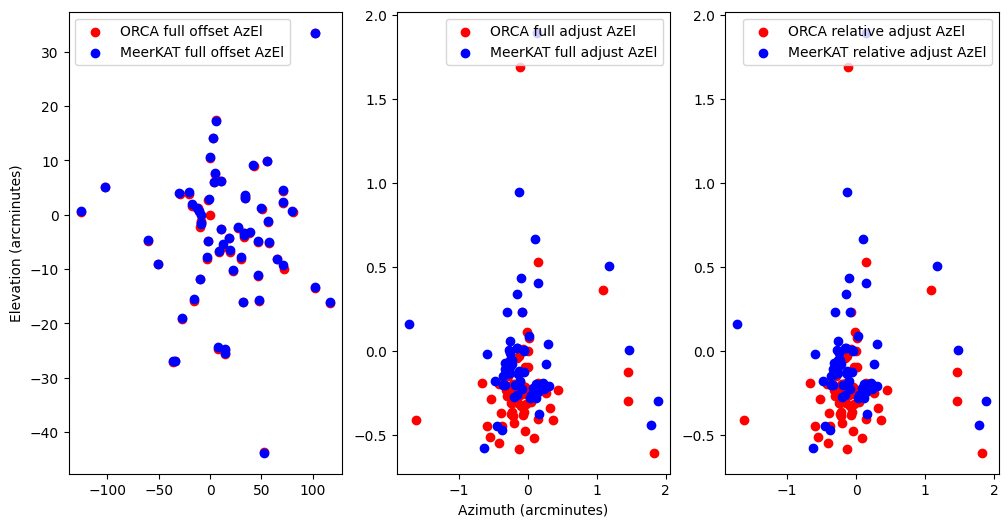

In [15]:
# MeerKAT offsets are a function of time (nants, ntimes, 2)
meerkat_full_offset_azel = np.median(meerkat_full_offset_azel, axis=1)
meerkat_full_adjust_azel = np.median(meerkat_full_adjust_azel, axis=1)
meerkat_relative_adjust_azel = np.median(meerkat_relative_adjust_azel, axis=1)


# Make plots 
plt.figure(figsize=(12, 6))

if fit_on_plane:
    plt.subplot(131)
    plt.scatter(full_offset_azel[:,0]*60., 
                full_offset_azel[:,1]*60., 
                c="r", label="ORCA full offset AzEl")
    plt.scatter(meerkat_full_offset_azel[:,0]*60., 
                meerkat_full_offset_azel[:,1]*60., 
                c="b", label="MeerKAT full offset AzEl")
    plt.ylabel("Elevation (arcminutes)")
    plt.legend()


    plt.subplot(132)
    plt.scatter(full_adjust_azel[:,0]*60., 
                full_adjust_azel[:,1]*60., 
                c="r", label="ORCA full adjust AzEl")
    plt.scatter(meerkat_full_adjust_azel[:,0]*60., 
                meerkat_full_adjust_azel[:,1]*60., 
                c="b", label="MeerKAT full adjust AzEl")
    plt.xlabel("Azimuth (arcminutes)")
    plt.legend()

    plt.subplot(133)
    plt.scatter(relative_adjust_azel[:,0]*60., 
                relative_adjust_azel[:,1]*60., 
                c="r", label="ORCA relative adjust AzEl")
    plt.scatter(meerkat_relative_adjust_azel[:,0]*60., 
                meerkat_relative_adjust_azel[:,1]*60., 
                c="b", label="MeerKAT relative adjust AzEl")
    plt.legend()
else:
    plt.scatter(el_cross_el[:,0]*60., el_cross_el[:,1]*60.)
    
    # Update Meerkat plot to el and cross-el
    plt.scatter(meerkat_relative_adjust_azel[:,0]*60., 
                meerkat_relative_adjust_azel[:,1]*60., 
                c="b", label="MeerKAT relative adjust AzEl")

In [16]:
# Save the computed offsets for each averaging option of the gain amplitudes
# np.save("no_avg.npy", full_azel_offset)
# np.save("mean_avg.npy", full_azel_offset)
# np.save("median_avg.npy", full_azel_offset)

# no_avg = np.load("no_avg.npy")
# mean_avg = np.load("mean_avg.npy")
# median_avg = np.load("median_avg.npy")
# print(no_avg.shape, mean_avg.shape, median_avg.shape)

# plt.scatter(no_avg[:,0], no_avg[:,1], c="r", label="No averaging")
# plt.scatter(mean_avg[:,0], mean_avg[:,1], c="b", label="Mean averaging")
# plt.scatter(median_avg[:,0], median_avg[:,1], c="g", label="Median averaging")
# plt.scatter(relative_az_adjust*60., relative_el_adjust*60., c="m", label="MeerKAT offsets")

# plt.xlabel("Azimuth offset (arcminutes)")
# plt.ylabel("Elevation offset (arcminutes)")
# plt.legend()

In [17]:
def construct_antennas(xyz, diameter, station):
    """
    Construct list of katpoint antenna objects
    based on telescope configuration information.

    :param xyz: xyz coordinates of antenna positions in [nants, 3]
    :param diameter: Diameter of dishes in [nants]
    :param station: List of the antenna names [nants]
    :return: a set of katpoint.Antenna objects
    """
    latitude, longitude, altitude = katpoint.ecef_to_lla(
        x_m=xyz[:, 0], y_m=xyz[:, 1], z_m=xyz[:, 2]
    )

    ants = []
    for ant_name, diam, lat, long, alt in zip(
        station, diameter, latitude, longitude, altitude
    ):
        # Antenna information
        # The beamwidth is HPBW of an antenna: k * lambda/D
        # We use an estimate of k=1.22 but not used in
        # calculating the beamwidth as k is passed from
        # the command line. The "beamwidth" as used in ant is
        # actually referring to the beamwidth factor, k.
        ant = katpoint.Antenna(
            name=ant_name,
            latitude=lat,
            longitude=long,
            altitude=alt,
            diameter=diam,
            delay_model=None,
            pointing_model=None,
            beamwidth=1.22,
        )
        ants.append(ant)

    return ants

# Simulated data with global_pe

In [18]:
# This is not updated to fit in el and cross-el
nants = 4
num_chunks = 8

msfiles = sorted(glob.glob("/mnt/storage-main/main/ska/meerkat/orc-1690/added_offset_*.ms/"))
freqs = table(msfiles[0]+"::SPECTRAL_WINDOW", ack=False).getcol("CHAN_FREQ")[0]
print(freqs.shape)

channels = np.arange(len(freqs)).reshape(num_chunks, -1)
print(channels.shape)

(32,)
(8, 4)


In [19]:
ant_pos = table(msfiles[0]+"::ANTENNA", ack=False).getcol("POSITION")
ant_diameter = table(msfiles[0]+"::ANTENNA", ack=False).getcol("DISH_DIAMETER")
ant_name = table(msfiles[0]+"::ANTENNA", ack=False).getcol("NAME")
ants = construct_antennas(xyz=ant_pos, diameter=ant_diameter, station=ant_name)
ants

[<katpoint.Antenna 'SKA001' diam=15.0m at 0x7fc11286cc70>,
 <katpoint.Antenna 'SKA036' diam=15.0m at 0x7fc11286c6d0>,
 <katpoint.Antenna 'SKA063' diam=15.0m at 0x7fc11286caf0>,
 <katpoint.Antenna 'SKA100' diam=15.0m at 0x7fc112871490>]

In [20]:
x_per_scan = np.zeros((len(msfiles), nants, 2))
y_per_scan = np.zeros((len(msfiles), nants, num_chunks))
for i in range(len(msfiles)):
    # Get the x-parameter
    pointing_table = table(msfiles[i]+"::POINTING", ack=False)
    source_offset = pointing_table.getcol("SOURCE_OFFSET")
    source_offset = source_offset.mean(axis=0)
    x_per_scan[i,] = source_offset
    
    
    for j,chan in enumerate(channels):
        start_chan = chan[0]
        end_chan = chan[-1]
        vis = create_visibility_from_ms(msname=msfiles[i], 
                                        start_chan=start_chan, 
                                        end_chan=end_chan, 
                                        ack=False, 
                                        datacolumn="DATA")
        gt = solve_gaintable(vis=vis[0], 
                             phase_only=False, 
                             crosspol=False, 
                             normalise_gains=None, 
                             jones_type="G", 
                             timeslice=None)
        gt_amp = np.abs(gt.gain.data)
        gt_amp = np.dstack((gt_amp[:, :, :, 0, 0], gt_amp[:, :, :, 1, 1]))
        gt_amp = gt_amp[0,].mean(axis=1)
        y_per_scan[i, :, j] = gt_amp

y_per_scan = np.moveaxis(y_per_scan, 0, 2)

In [21]:
x_per_scan.shape, y_per_scan.shape

((5, 4, 2), (4, 8, 5))

In [22]:
freqs = freqs.reshape(num_chunks, -1).mean(axis=1)
freqs.shape

(8,)

In [23]:
# For each antenna, we fit the beams to the gains in each usable num_chunk
# So for each scan, we get solutions for each num_chunk 
beams = {} # for collecting the fitted beam solutions 

for i, antenna in enumerate(ants):
    x_param = x_per_scan[:, i].T
    for chunk in range(num_chunks):
        print(f"Fitting beams to {antenna.name} in Band {chunk+1}")
        y_param = y_per_scan[i, chunk] 
        print(x_param.shape, y_param.shape)

        # Compute the expected beamwidth
        wavelength = katpoint.lightspeed / freqs[chunk] 
        expected_width = np.sqrt(2)*np.degrees(np.array(beamwidth_factor)*wavelength/antenna.diameter)

        # Begin fitting 
        fitted_beam = BeamPatternFit(centre=(0.,0.), 
                                     width=expected_width, 
                                     height=1.0)
        fitted_beam.fit(x_param, 
                        y_param, 
                        std_y=1.0, 
                        thresh_width=thresh_width) 

        # Collect the fitted beams
        beams_freq = beams.get(antenna.name, [None] * num_chunks)
        beams_freq[chunk] = fitted_beam
        beams[antenna.name] = beams_freq 
            

Fitting beams to SKA001 in Band 1
(2, 5) (5,)
Fitted centre: [ 0.04626069 -9.69403451]
Expected width: [1.21059377 1.36191799]
Fitted width: [9.06652211e-02 5.16976604e+02]
Norm width: [7.48931833e-02 3.79594518e+02]
Fitting beams to SKA001 in Band 2
(2, 5) (5,)
Fitted centre: [ 0.04338556 12.12581608]
Expected width: [1.19684353 1.34644897]
Fitted width: [ 0.0993963  34.06861595]
Norm width: [ 0.0830487  25.30256742]
Fitting beams to SKA001 in Band 3
(2, 5) (5,)
Fitted centre: [ 0.04338363 11.44114915]
Expected width: [1.18340215 1.33132741]
Fitted width: [ 0.09940658 28.99689684]
Norm width: [ 0.08400068 21.78043999]
Fitting beams to SKA001 in Band 4
(2, 5) (5,)
Fitted centre: [ 0.04338506 11.60814446]
Expected width: [1.17025932 1.31654173]
Fitted width: [ 0.09939836 32.1990843 ]
Norm width: [ 0.08493704 24.45732142]
Fitting beams to SKA001 in Band 5
(2, 5) (5,)
Fitted centre: [0.04339176 2.60534565]
Expected width: [1.15740521 1.30208086]
Fitted width: [9.93604932e-02 1.97826512e+0

/home/wangfeng/python/rascil/lib/python3.9/site-packages/scikits/fitting/gaussian.py:194: RuntimeWarning: invalid value encountered in sqrt
  std_params = np.sqrt(np.diag(self._interp.cov_params))


Fitted centre: [ 0.04338414 10.80400971]
Expected width: [1.13252592 1.27409166]
Fitted width: [ 0.09940335 28.99382795]
Norm width: [ 0.08777137 22.75646941]
Fitting beams to SKA001 in Band 8
(2, 5) (5,)
Fitted centre: [0.04339172 8.29433597]
Expected width: [1.12048311 1.2605435 ]
Fitted width: [9.93612119e-02 2.12774672e+03]
Norm width: [8.86771169e-02 1.68795977e+03]
Fitting beams to SKA036 in Band 1
(2, 5) (5,)
Fitted centre: [ 0.24450144 -0.00749626]
Expected width: [1.21059377 1.36191799]
Fitted width: [0.24029421 0.02064668]
Norm width: [0.19849285 0.01516   ]
Fitting beams to SKA036 in Band 2
(2, 5) (5,)
Fitted centre: [-4.94408717 19.3479913 ]
Expected width: [1.19684353 1.34644897]
Fitted width: [3.86576879e+00 6.81105627e+03]
Norm width: [3.22997007e+00 5.05853278e+03]
Fitting beams to SKA036 in Band 3
(2, 5) (5,)
Fitted centre: [-5.08986091 13.95697445]
Expected width: [1.18340215 1.33132741]
Fitted width: [3.92154907e+00 6.94629782e+03]
Norm width: [3.31379243e+00 5.21757

In [35]:
beams.get('SKA001', [])

In [44]:

# Get all your valid fits and perform a weighted average of the computed offsets 
full_azel_offset = np.zeros((len(ants), 2))    
for i, antenna in enumerate(ants):
    print(antenna.name)
    beams_freq = beams.get(antenna.name, [])
    if num_chunks > 1:
        beams_freq = [b for b in beams_freq if b is not None and b.is_valid]

        if not beams_freq: 
            print(f"{antenna.name} had no valid primary beam fitted")
            continue
        offsets_freq = np.array([b.centre for b in beams_freq])
        offsets_freq_std = np.array([b.std_centre for b in beams_freq])
        weights_freq = 1. / offsets_freq_std ** 2

        # Do weighted average of offsets over frequency chunks
        results = np.average(offsets_freq, axis=0, weights=weights_freq, returned=True)
        pointing_offset = results[0]
        pointing_offset_std = np.sqrt(1. / results[1])
    
        # The fitted centre is directly the AzEl offsets 
        full_azel_offset[i] = pointing_offset

print("Computing the azel offsets in arcminutes ...")
full_azel_offset = katpoint.wrap_angle(full_azel_offset)*60.

SKA001
SKA001 had no valid primary beam fitted
SKA036
SKA036 had no valid primary beam fitted
SKA063
SKA063 had no valid primary beam fitted
SKA100
SKA100 had no valid primary beam fitted
Computing the azel offsets in arcminutes ...


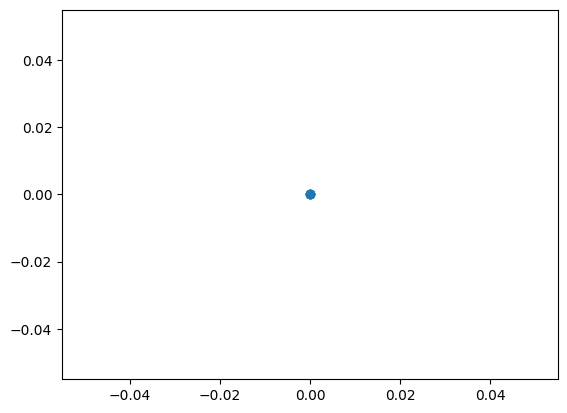

In [45]:
plt.scatter(full_azel_offset[:,0], full_azel_offset[:,1])

In [26]:
ra, dec = table(msfiles[0]+"::SOURCE", ack=False).getcol("DIRECTION")[0]
np.degrees(ra), np.degrees(dec)
target = katpoint.construct_radec_target(f"{np.degrees(ra)}", f"{np.degrees(dec)}")
target

<katpoint.Target 'Ra: 19:39:24.00 Dec: -30:00:00.0' body=radec at 0x7fc112ab2640>

In [27]:
times = table(msfiles[0]+"::POINTING", ack=False).getcol("TIME")
pos0 = np.array(target.azel(times, antenna)).T
pos0.shape

(240, 2)

In [37]:
target_x = np.zeros((5, 4, 240))
target_y = np.zeros((5, 4, 240))
for i in range(len(msfiles)):
    pointing_table = table(msfiles[i]+"::POINTING", ack=False)
    requested_pointing = pointing_table.getcol("TARGET")
    actual_pointing = pointing_table.getcol("DIRECTION")
    
    # print(requested_pointing[:,j,0].shape)
    for j,antenna in enumerate(ants):
        #for j,time in enumerate(times):
        x, y = katpoint.projection.sphere_to_plane_arc(az0=np.radians(requested_pointing[:,j,0]), 
                                                       el0=np.radians(requested_pointing[:,j,1]), 
                                                       az=np.radians(actual_pointing[:,j,0]), 
                                                       el=np.radians(actual_pointing[:,j, 1]))
        target_x[i] = np.degrees(x)
        target_y[i] = np.degrees(y)

In [38]:
target_x.shape, target_y.shape

((5, 4, 240), (5, 4, 240))

In [39]:
dish_coord = np.dstack((np.moveaxis(target_x, 2, 0).mean(axis=0), 
                        np.moveaxis(target_y, 2, 0).mean(axis=0)))
dish_coord.shape

(5, 4, 2)

In [40]:
y_per_scan.shape

(4, 8, 5)

In [41]:
x_per_scan = dish_coord

In [42]:
freqs.shape

(8,)

In [43]:
# For each antenna, we fit the beams to the gains in each usable num_chunk
# So for each scan, we get solutions for each num_chunk 
beams = {} # for collecting the fitted beam solutions 

for i, antenna in enumerate(ants):
    x_param = x_per_scan[:, i].T
    for chunk in range(num_chunks):
        print(f"Fitting beams to {antenna.name} in Band {chunk+1}")
        y_param = y_per_scan[i, chunk] 
        print(x_param.shape, y_param.shape)

        # Compute the expected beamwidth
        wavelength = katpoint.lightspeed / freqs[chunk] 
        expected_width = np.sqrt(2)*np.degrees(np.array(beamwidth_factor)*wavelength/antenna.diameter)

        # Begin fitting 
        fitted_beam = BeamPatternFit(centre=(0.,0.), 
                                     width=expected_width, 
                                     height=1.0)
        fitted_beam.fit(x_param, 
                        y_param, 
                        std_y=1.0, 
                        thresh_width=thresh_width) 

        # Collect the fitted beams
        beams_freq = beams.get(antenna.name, [None] * num_chunks)
        beams_freq[chunk] = fitted_beam
        beams[antenna.name] = beams_freq 
            

Fitting beams to SKA001 in Band 1
(2, 5) (5,)
Fitted centre: [ -0.07140022 -21.50247071]
Expected width: [1.21059377 1.36191799]
Fitted width: [7.54752757e-02 3.19502092e+03]
Norm width: [6.23456667e-02 2.34597159e+03]
Fitting beams to SKA001 in Band 2
(2, 5) (5,)
Fitted centre: [1.89098376e-02 3.04080774e+01]
Expected width: [1.19684353 1.34644897]
Fitted width: [8.65906697e-03 1.51658465e+03]
Norm width: [7.2349198e-03 1.1263588e+03]
Fitting beams to SKA001 in Band 3
(2, 5) (5,)
Fitted centre: [-0.03629706 29.36872642]
Expected width: [1.18340215 1.33132741]
Fitted width: [8.30755219e-02 1.33539626e+03]
Norm width: [7.02005841e-02 1.00305623e+03]
Fitting beams to SKA001 in Band 4
(2, 5) (5,)
Fitted centre: [0.01910017 8.20015019]
Expected width: [1.17025932 1.31654173]
Fitted width: [6.35169252e-03 5.58872709e+03]
Norm width: [5.42759406e-03 4.24500565e+03]
Fitting beams to SKA001 in Band 5
(2, 5) (5,)
Fitted centre: [-7.22812114  0.15850093]
Expected width: [1.15740521 1.30208086]
F